In [1]:
import torch
import torch.nn as nn
from transformers import BertModel, BertPreTrainedModel
from transformers import AutoModel, AutoConfig

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class Model(BertPreTrainedModel) :
    def __init__(self, output_classes, config) :
        super().__init__(config)
        self.bert = BertModel.from_pretrained("skt/kobert-base-v1", config=config)
        self.output_layer = nn.Linear(config.hidden_size, output_classes)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)


    def forward(self, input_ids, attention_mask) :
        hidden_state = self.bert(input_ids = input_ids,
                                 attention_mask = attention_mask)
        data = hidden_state[1]
        output = self.dropout(data)
        output = self.dense(output)
        output = torch.tanh(output)
        output = self.dropout(output)
        output = self.output_layer(output)
        return output

conf =  AutoConfig.from_pretrained("skt/kobert-base-v1")
model = Model(output_classes = 2, config = conf).to(device)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [2]:
#import dataframe
import pandas as pd
df_inf = pd.read_csv('news01.csv')

#get tokenizer
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1', last_hidden_states=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [3]:
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


class CustomDataset(Dataset) :
    def __init__(self, dataframe, tokenizer, max_length) :
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, x) :
        data = self.dataframe.loc[x].title + '[CLS][PAD][PAD]' + self.dataframe.loc[x].content
        data = self.tokenize(data)
        input_ids = data.input_ids.squeeze()
        attention_mask = data.attention_mask.squeeze()

        return input_ids, attention_mask

    def tokenize(self, data) :
        token = self.tokenizer(data, padding = 'max_length', max_length = self.max_length, truncation = True, return_tensors = "pt")
        del token['token_type_ids']
        return token
    
    def __len__(self) :
        return len(self.dataframe)

test_dataset = CustomDataset(dataframe = df_inf,
                             tokenizer = tokenizer,
                             max_length = 512)
test_dataloader = DataLoader(test_dataset, batch_size = 8, num_workers = 4, shuffle = False)

def inference(model, dataloader) :
    outputs = []
    model.eval()
    with torch.no_grad() :
        for batch, (input_ids, attention_mask) in enumerate(tqdm(dataloader)) :
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            outs = model(input_ids = input_ids, attention_mask = attention_mask)
            outs = torch.softmax(outs, dim=1)
            outputs.append(outs)
    return outputs

In [55]:
data = []

for i in range(5):
    model.load_state_dict(torch.load(f'./models/best_w_{i}.pth'))
    data.append(inference(model, test_dataloader))

100%|██████████| 45/45 [00:02<00:00, 16.44it/s]


In [65]:
data[0][0]


array([[1.2459039e-03, 9.9875414e-01],
       [3.4877434e-05, 9.9996507e-01],
       [2.5154266e-05, 9.9997485e-01],
       [9.9992955e-01, 7.0484981e-05],
       [5.8660531e-05, 9.9994135e-01],
       [4.3162177e-05, 9.9995685e-01],
       [3.4848446e-05, 9.9996519e-01],
       [2.7014319e-05, 9.9997294e-01]], dtype=float32)

In [84]:
import numpy as np

pro = 0


for i in range(5) :
    aa = []
    for a in range(len(data[0])) :
        aa.extend(data[0][a])
    ai = np.array(aa)
    pro += ai

In [90]:
sss = pro/5

In [95]:
np.shape(sss)

(355, 2)

In [99]:
t = pd.read_csv('inference.csv')

In [103]:
t.count()

0    355
1    355
dtype: int64

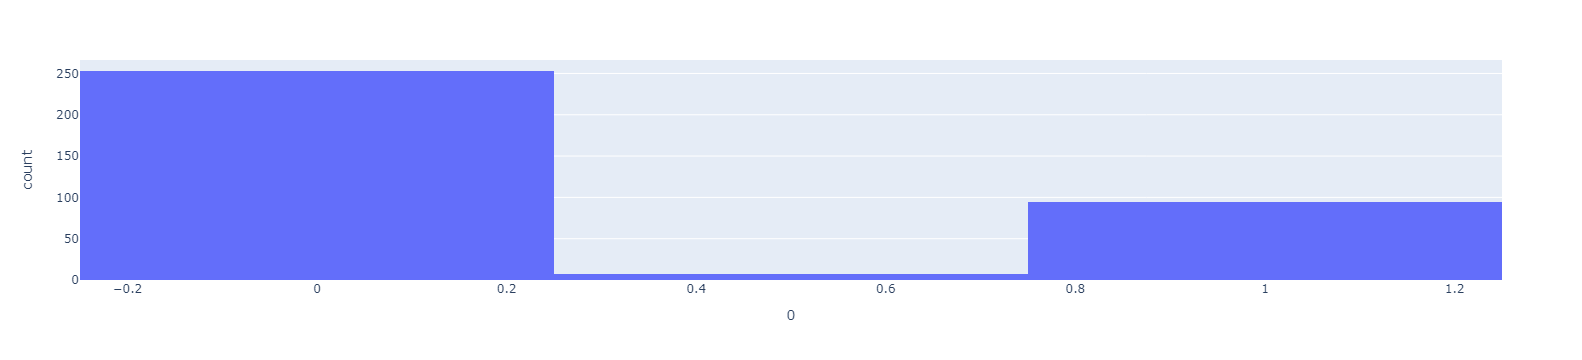

In [107]:
import plotly.express as px


fig = px.histogram(t, x='0', nbins= 2)
fig.show()